In [1]:
import logging
import os
from pathlib import Path
import shutil

import cm1.input.sounding
from cm1.run import PBS, CM1Run
from cm1.utils import skewt, TMPDIR
import f90nml
import metpy.calc as mpcalc
from metpy.units import units
import pandas as pd

In [2]:
# Path to the CM1 repository
CM1 = Path(os.getenv("SCRATCH")) / "cm1"

testcase = "supercell"
run_dir = CM1 / f"run_{testcase}"
os.makedirs(run_dir, exist_ok=True)

# Copy all files from testcase configuration directory to run directory
shutil.copytree(CM1 / "run/config_files" / testcase, run_dir, dirs_exist_ok=True)

# Copy radiation data and model executable to run directory.
for file in ["RRTMG_LW_DATA", "RRTMG_SW_DATA", "cm1.exe"]:
    shutil.copy(CM1 / f"run/{file}", run_dir / file)

# Read Namelist object from namelist path.
namelist_path = run_dir / "namelist.input"
namelist = f90nml.read(namelist_path)

# Modify values in the namelist
namelist["param9"]["output_format"] = 2
namelist["param9"]["output_filetype"] = 1
namelist["param2"]["isnd"] = 7

# Write updated namelist in run directory.
namelist.write(namelist_path, force=True)
logging.info(f"Updated namelist saved to {namelist_path}")

valid_time = pd.to_datetime("20240525")
lon = -95 * units.degree_E
lat = 33 * units.degree_N

#ds = cm1.input.sounding.era5_model_level(valid_time, lon=lon, lat=lat)
ds = cm1.input.sounding.era5_aws(valid_time, lon=lon, lat=lat)
cm1.input.sounding.to_txt(ds)
ofile = run_dir / "input_sounding"
with open(ofile, "w") as f:
    f.write(cm1.input.sounding.to_txt(ds))
    logging.warning(ofile)

pbs_config = PBS(
    name=testcase,
    account="NMMM0021",
    walltime="01:00:00",
    nodes=1,
    run_dir=run_dir,
)
cm1_run = CM1Run(namelist=namelist, pbs_config=pbs_config)
#cm1_run.submit_job()
cm1_run.run(background=True)

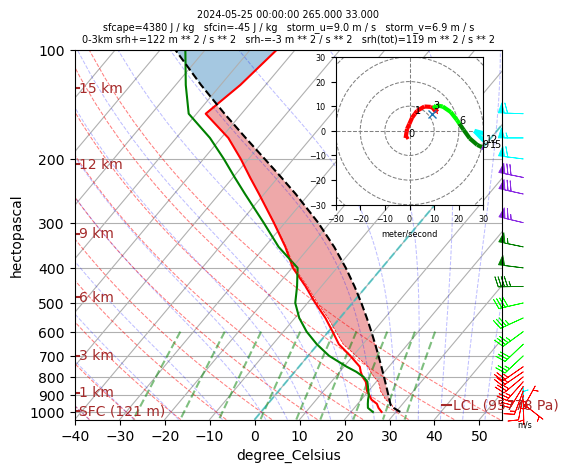

In [3]:
skewt(ds)

In [4]:
import metpy.calc as mpcalc
ds["Td"] = mpcalc.dewpoint_from_specific_humidity(ds.P, ds.Q).metpy.convert_units("K")

In [5]:
ds.sel(level=400*units.hPa)

<xarray.Dataset> Size: 112B
Dimensions:                        ()
Coordinates:
    longitude                      float64 8B 265.0
    latitude                       float64 8B 33.0
    level                          float64 8B 400.0
    time                           datetime64[ns] 8B 2024-05-25
Data variables: (12/17)
    Q                              float32 4B <Quantity(2.1789472103118896, '...
    T                              float32 4B <Quantity(253.35317993164062, '...
    U                              float32 4B <Quantity(24.446212768554688, '...
    V                              float32 4B <Quantity(-3.0855255126953125, ...
    W                              float32 4B <Quantity(-6.171462059020996, '...
    Z                              float32 4B <Quantity(7520.70654296875, 'me...
    ...                             ...
    VAR_2D                         float32 4B <Quantity(298.0002746582031, 'k...
    surface_potential_temperature  float32 4B <Quantity(301.0862121582031, 'k...
    surface_mixing_ratio           float32 4B <Quantity(0.020305698737502098,...
    Zsfc                           float32 4B <Quantity(121.11624145507812, '...
    theta                          float64 8B <Quantity(329.1724690163249, 'k...
    Td                             float64 8B <Quantity(254.39995248201097, '...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.9.2
    CONVERSION_PLATFORM:  Linux crhtc41 5.14.21-150400.24.46-default #1 SMP P...
    CONVERSION_DATE:      Sun 04 Aug 2024 04:21:22 PM MDT
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Sun Aug  4 16:21:38 2024: ncks -4 -L 1 --baa=0 --pp...
    NCO:                  netCDF Operators version 5.1.9 (Homepage = http://n...

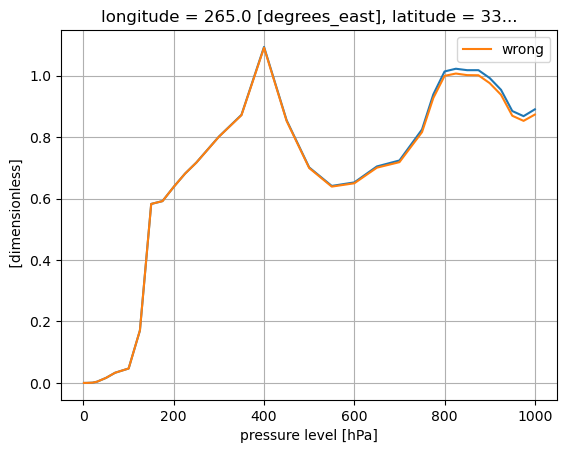

In [6]:
c, = (mpcalc.vapor_pressure(ds.P, mpcalc.mixing_ratio_from_specific_humidity(ds.Q)) / mpcalc.saturation_vapor_pressure(ds.T)).metpy.convert_to_base_units().plot()
c.axes.grid()
(mpcalc.vapor_pressure(ds.P, ds.Q) / mpcalc.saturation_vapor_pressure(ds.T)).metpy.convert_to_base_units().plot(ax=c.axes, label="wrong")
c.axes.legend()


In [7]:
from metpy.calc import lcl, lfc, surface_based_cape_cin
from metpy.testing import assert_almost_equal
import matplotlib.pyplot as plt
import numpy as np
import xarray
def test_sensitive_sounding():
    """Test quantities for a sensitive sounding (#902)."""
    # This sounding has a very small positive area in the low level. It's only captured
    # properly if the parcel profile includes the LCL, otherwise it breaks LFC and CAPE
    p = units.Quantity([1004., 1000., 943., 928., 925., 850., 839., 749., 700., 699.,
                        603., 500., 404., 400., 363., 306., 300., 250., 213., 200.,
                        176., 150.], 'hectopascal')
    t = units.Quantity([24.6, 24.5, 19.8, 21.6, 21.4, 20.4, 20.2, 14.4, 13.2, 13., 6.8, -3.3,
                        -13.1, -13.7, -17.9, -25.5, -26.9, -37.9, -46.7, -48.7, -52.1, -58.9],
                       'degC')
    td = units.Quantity([22.3, 22.1, 19.2, 20.5, 20.4, 18.4, 17.4, 8.4, -2.8, -3.0, -15.2,
                         -20.3, -29.1, -27.7, -24.9, -39.5, -41.9, -51.9, -60.7, -62.7, -65.1,
                         -71.9], 'degC')
    lfc_pressure, lfc_temp = lfc(p, t, td)
    ds = xarray.Dataset(
        dict(
            P=("level",p),
            T=("level",t),
            Td=("level", td),
            Z=("level", len(p) * [0] *units.m),
            U=("level", len(p) * [0] *units.m/units.s),
            V=("level", len(p) * [0] *units.m/units.s),
        ),
        coords = {"level":p},
    )
    ds["Q"] = mpcalc.specific_humidity_from_dewpoint(ds["P"], ds["Td"])
    ds["Zsfc"] = 0
    ds["Zsfc"] *= units.m
    ds["SP"] = 1004
    ds["SP"] *= units.hPa

    ax = skewt(ds, ptop=200*units.hPa, fig = plt.figure(figsize=(10,8)), xlim=(-10,40), rotation=40)
    lcl_pressure, lcl_temp = lcl(ds["P"], ds["T"], ds["Td"])
    print(lcl_pressure[0], lcl_temp[0])
    ax.plot(lcl_pressure[0], lcl_temp[0], 'ko', markerfacecolor='black')
    ax.plot(lfc_pressure, lfc_temp, 'k+', markerfacecolor='black')
    #assert_almost_equal(lfc_pressure, 952.8445 * units.mbar, 2)
    #assert_almost_equal(lfc_temp, 20.94469 * units.degC, 2)

    pos, neg = surface_based_cape_cin(p, t, td)
    assert_almost_equal(pos, 0.106791 * units('J/kg'), 3)


/Users/ahijevyc/sysdisk1/MetPy/src/metpy/interpolate/one_dimension.py:160: RuntimeWarning: invalid value encountered in divide
  var_interp = var[below] + (var[above] - var[below]) * ((x_array - xp[below])


970.7424492314431 hectopascal 21.748021100928042 degree_Celsius


AssertionError: 
Arrays are not almost equal to 3 decimals
 ACTUAL: np.float64(5.580565243545871)
 DESIRED: 0.106791

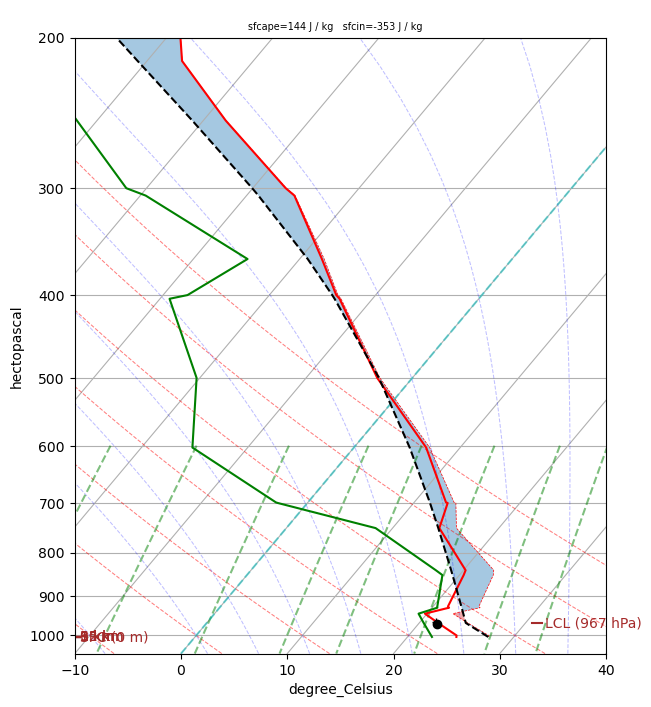

In [8]:
test_sensitive_sounding()

In [ ]:
p = units.Quantity([1004., 1000., 943., 928., 925., 850., 839., 749., 700., 699.,
                    603., 500., 404., 400., 363., 306., 300., 250., 213., 200.,
                    176., 150.], 'hectopascal')
t = units.Quantity([25.1, 24.5, 20.2, 21.6, 21.4, 20.4, 20.2, 14.4, 13.2, 13., 6.8, -3.3,
                    -13.1, -13.7, -17.9, -25.5, -26.9, -37.9, -46.7, -48.7, -52.1, -58.9],
                   'degC')
td = units.Quantity([21.9, 22.1, 19.2, 20.5, 20.4, 18.4, 17.4, 8.4, -2.8, -3.0, -15.2,
                     -20.3, -29.1, -27.7, -24.9, -39.5, -41.9, -51.9, -60.7, -62.7, -65.1,
                     -71.9], 'degC')
xarray.Dataset(dict(P=("level",p), T=("level",t), Td=("level", td), Zsfc=[0]*units.m, SP=[1004]*units.hPa), coords={"level":p})

970.7113556117489 hectopascal 21.349157267204703 degree_Celsius


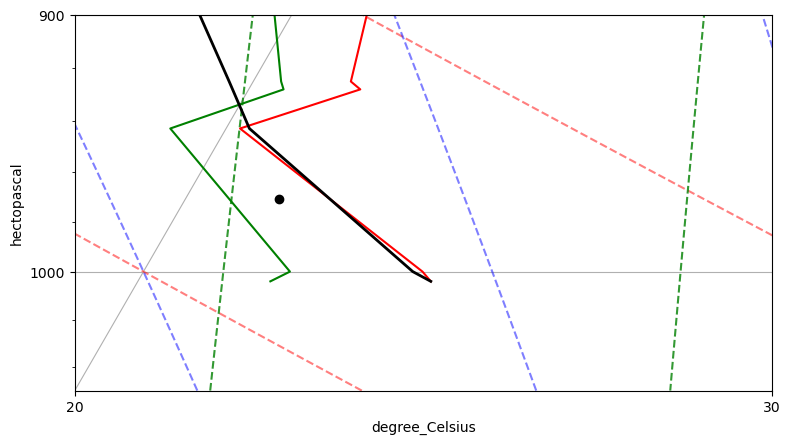

In [9]:
import matplotlib.pyplot as plt
import numpy as np

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

p = np.array([1004.,  1000.,   943.,   928.,   925.,   850.,   839.,   749.,   700.,   699.,
              603.,   500.,   404.,   400.,   363.,   306.,   300.,   250.,   213.,   200.,
              176.,   150.,   120.,   105.,   100.,    70.,    66.,    58.,    50.,    40.,
              33.,    30.,    23.,    20.,    16.]) * units('hPa')

T = np.array([24.2,  24.,   20.2,  21.6,  21.4,  20.4,  20.2,  14.4,  13.2,  13.,    6.8,  -3.3,
              -13.1, -13.7, -17.9, -25.5, -26.9, -37.9, -46.7, -48.7, -52.1, -58.9, -67.3, -66.5,
              -66.7, -65.1, -66.1, -60.9, -60.5, -57.7, -50.1, -50.3, -50.1, -47.9, -43.1])  \
              * units('degC')

Td = np.array([2.19000000e+01,   2.21000000e+01,   1.92000000e+01,   2.05000000e+01,
               2.04000000e+01,   1.84000000e+01,   1.74000000e+01,   8.40000000e+00,
               -2.80000000e+00,  -3.00000000e+00,  -1.52000000e+01,  -2.03000000e+01,
               -2.91000000e+01,  -2.77000000e+01,  -2.49000000e+01,  -3.95000000e+01,
               -4.19000000e+01,  -5.19000000e+01,  -6.07000000e+01,  -6.27000000e+01,
               -6.51000000e+01,  -7.19000000e+01,   9.99999000e+05,   9.99999000e+05,
               9.99999000e+05,   9.99999000e+05,   9.99999000e+05,   9.99999000e+05,
               9.99999000e+05,   9.99999000e+05,   9.99999000e+05,   9.99999000e+05,
               9.99999000e+05,   9.99999000e+05,   9.99999000e+05]) * units('degC')

Td[Td.m>9e5] = -68 * units('degC')

# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

print(lcl_pressure, lcl_temperature)

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.ax.set_ylim(1050, 900)
skew.ax.set_xlim(20, 30)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.show()